# Walmart Sales Forecast

**Description:**

Author: Sue Huynh

Date: May 17, 2022

Data Source: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast

**Objectives:**
In retail industry, predicting sales is very important to reduce costs and risks in every other aspects of the business. With the sales records from 45 stores of Walmart including other information in the train dataset, I am trying to forecast the weekly sales in the test dataset using time series forecasting models.

**Action Items:**
1. Explore and clean data
2. Visualize data
3. Implement models


## 1. Load libraries and datasets

In [1]:
#data analysis
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot as auto_corr

#visualization
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#datetime
import math
from datetime import datetime
from datetime import timedelta

In [2]:
df_features = pd.read_csv('C:/Users/nguye/OneDrive/Desktop/Data Projects/Walmart Sales Forecast/features.csv')
df_stores = pd.read_csv('C:/Users/nguye/OneDrive/Desktop/Data Projects/Walmart Sales Forecast/stores.csv')
df_train = pd.read_csv('C:/Users/nguye/OneDrive/Desktop/Data Projects/Walmart Sales Forecast/train.csv')
df_test= pd.read_csv('C:/Users/nguye/OneDrive/Desktop/Data Projects/Walmart Sales Forecast/test.csv')

## 2. Explore datasets

In [3]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### Merge datasets 

From the beginning, the train dataset has only IsHoliday features, which could limit our observations on the features impacting  the weekly sales. Hence, I will merge the train dataset with the features and stores dataset for better exploration

In [7]:
df = df_train.merge(df_features,on=['Store','Date'],how='inner').merge(df_stores,on=['Store'],how='inner')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


As both train dataset and feature dataset have IsHoliday columns, we will drop one IsHoliday column and rename the other

In [9]:
df.drop('IsHoliday_y',axis=1,inplace=True)

In [10]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

Now, our dataframe looks like:

In [11]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


## 3. Clean data

Let's have a glance at numeric values in the dataframe

In [12]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [14]:
df['Dept'].nunique()

81

In [13]:
df['Store'].nunique()

45

In [ ]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Observation:

* Our dataframe has 421,570 records
* There are 45 unique stores and 81 unique departments although there are department id in the range of (90,99)
* Weekly_Sales columns has a few negative values
* The Markdown columns showing the price discount (promotion) at the stores has large outliers because the Q3 is much smaller the corresponding max values

Actions:
* Consider eliminate negative sales values



In [15]:
df.loc[df['Weekly_Sales'] <=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


There are 1358 records having negative values, which accounts for ~0.003 = 0.3% of the original dataset, so I think it does no harm when eliminate these values

In [16]:
df = df.loc[df['Weekly_Sales']>=0]
df.shape

(420285, 16)

Next, I find out that our train dataframe has records from February 5, 2010 to October 26th, 2012

In [17]:
df['Date'].head(5).append(df['Date'].tail(5))

C:\Users\nguye\AppData\Local\Temp\ipykernel_21588\1507639958.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df['Date'].head(5).append(df['Date'].tail(5))


0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

## 4. Visualize data for insights

### IsHoliday feature

First, I want to see the sales difference in Non-Holiday (False) and Holiday (True) weeks

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

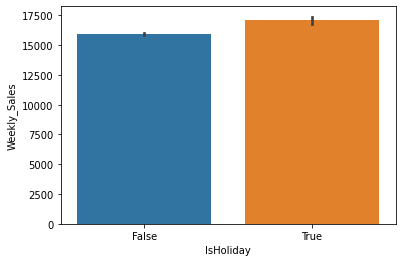

In [18]:
sns.barplot(data = df,x='IsHoliday',y='Weekly_Sales')

In [19]:
df['IsHoliday'].value_counts()

False    390722
True      29563
Name: IsHoliday, dtype: int64

In [20]:
df_holiday = df.loc[df['IsHoliday'] == True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [21]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

Observations:
* Sales in holiday weeks are around 1,000 - 2,000 **higher** than normal weeks
* There are 29,563 sales recorded in holiday weeks, which is equal to 0.07 of the normal weeks
* We also find out that there are only 10 holiday weeks in the dataset, which could be classify into 4 seasons Super Bowl, Labor Day, Thanksgiving, and Christmas for each year 
* For non-holiday weeks, the dataset has 133 unique days for the record of 390722 sales during those days

Actions:
* Create new features for each season to measure the sales difference

In [22]:
#super bowl
df.loc[(df['Date'] == '2010-02-12') | (df['Date'] == '2011-02-11') | (df['Date'] == '2012-02-10'),'Super Bowl'] = True
df.loc[(df['Date'] != '2010-02-12') & (df['Date'] != '2011-02-11') & (df['Date'] != '2012-02-10'),'Super Bowl'] = False

In [23]:
#labor
df.loc[(df['Date'] == '2010-09-10') | (df['Date'] == '2011-09-11') | (df['Date'] == '2012-09-07'),'Labor'] =True
df.loc[(df['Date'] != '2010-09-10') & (df['Date'] != '2011-09-11') & (df['Date'] != '2012-09-07'),'Labor'] =False

In [24]:
#thanksgiving
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [25]:
#christmas
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

Now, let's visualize the sales in each holiday types

<AxesSubplot:xlabel='Super Bowl', ylabel='Weekly_Sales'>

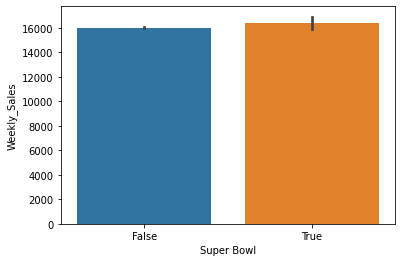

In [26]:
#superbowl
sns.barplot(data=df,x='Super Bowl',y='Weekly_Sales')

<AxesSubplot:xlabel='Labor', ylabel='Weekly_Sales'>

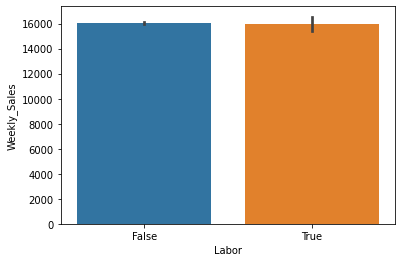

In [27]:
#laborday
sns.barplot(data=df,x='Labor',y='Weekly_Sales')

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

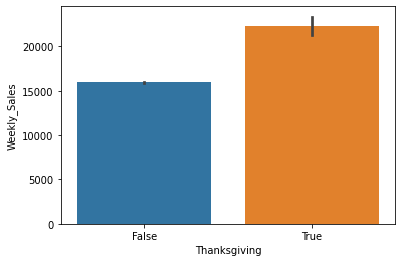

In [28]:
#thanksgiving
sns.barplot(data=df,x='Thanksgiving',y='Weekly_Sales')

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

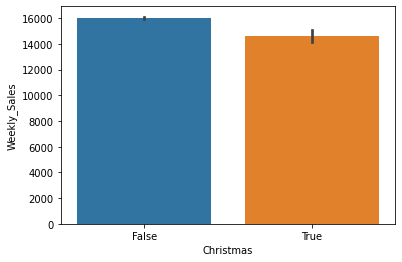

In [29]:
#christmas
sns.barplot(data=df,x='Christmas',y='Weekly_Sales')

In [30]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15949.958317
True     17092.566220
Name: Weekly_Sales, dtype: float64

Observations:
* Sales in holiday weeks are higher than that in non-holiday weeks, except for Christmas weeks
* Among the 3 holidays having sales in holiday higher than non-holiday, Sales in Thanksgiving week is significantly higher.

Assumptions:
* The data suggests that customers might buy their Christmas gifts or decorations a few weeks before the holidays, even during the Thanksgiving holiday. This assumption is quite realistic because Christmas is a big event, requiring time and effort to prepare in advance.

### Store type features

In the next step, I will take a look at 'type' column to uncover some potential correlation between sales, holidays, and types

In [31]:
df['Type'].value_counts() * 100/ len(df)

A    51.154098
B    38.740141
C    10.105762
Name: Type, dtype: float64

Observations:
* Type A accounts for the majority of the datasets, 51.15%, following by store B (38.74%) and store C (10.10%)

Actions:
* Calculate and visualize average sales in each store types during each types of holidays

In [32]:
df.groupby(['Super Bowl','Type'])['Weekly_Sales'].mean()

Super Bowl  Type
False       A       20134.993683
            B       12284.349447
            C        9534.047011
True        A       20612.757674
            B       12463.412421
            C       10179.271884
Name: Weekly_Sales, dtype: float64

In [33]:
df.groupby(['Labor','Type'])['Weekly_Sales'].mean()

Labor  Type
False  A       20146.312102
       B       12290.814066
       C        9540.366537
True   A       20060.598111
       B       12098.648882
       C       10045.474040
Name: Weekly_Sales, dtype: float64

In [34]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
False         A       20040.981576
              B       12195.285567
              C        9545.326177
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [35]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()

Christmas  Type
False      A       20171.304550
           B       12299.610446
           C        9568.895179
True       A       18310.167535
           B       11483.973221
           C        8031.520607
Name: Weekly_Sales, dtype: float64

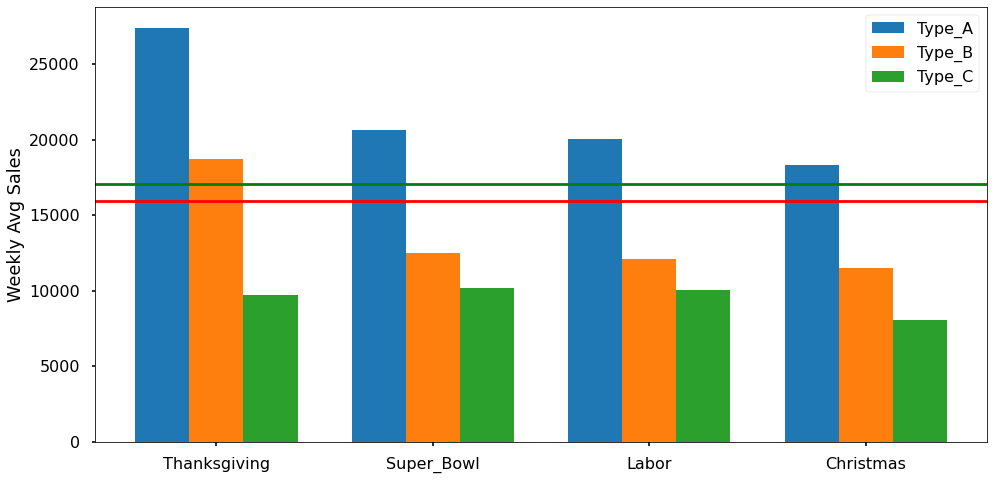

In [36]:
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor', 'Christmas']
A_means = [27397.78, 20612.76, 20060.60, 18310.17]
B_means = [18733.97, 12463.41, 12098.65, 11483.98]
C_means = [9696.57,10179.27,10045.47,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
fig1 = ax.bar(x - width, A_means, width, label='Type_A')
fig2 = ax.bar(x , B_means, width, label='Type_B')
fig3 = ax.bar(x + width, C_means, width, label='Type_C')

ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.axhline(y=15949.96, color = 'red') #non-holiday
plt.axhline(y=17092.57, color = 'green') #holiday

Observations:
* We could see that sales in Thanksgiving week is the highest.
* Sales in store A in every holiday are all higher than the average sales in holidays

In [37]:
df.sort_values(by='Weekly_Sales',ascending=False).head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super Bowl,Labor,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


Above, I retrieved the five highest sales and understandably, those are all in Thanksgiving weeks.

### Type and Size features

<AxesSubplot:xlabel='Type', ylabel='Size'>

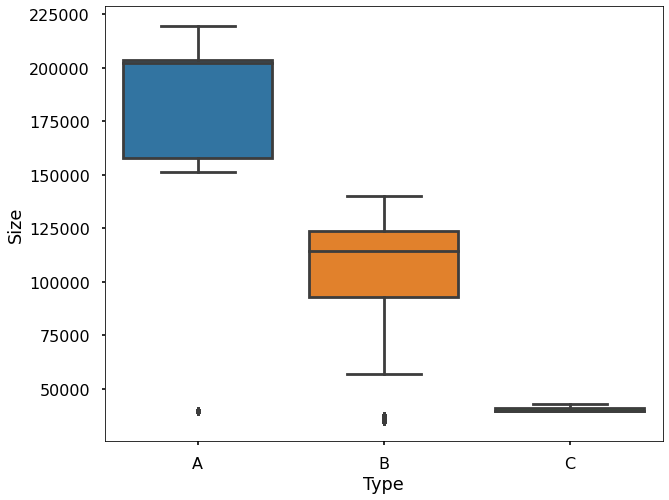

In [38]:
plt.figure(figsize=(10,8))
sns.boxplot(x='Type',y='Size',data=df)

Observation:
* We could see that most of store A is the biggest, following by store B and C. This observation could explain for the sales rank in store A,B,C. Customers are tend to buy more in bigger store, broader options, leading to higher sales in bigger stores

### Markdown features

From the description of dataframe at the very top, we could see that the markdown columns have a lot of NaN values. Let's see how many null values each column has.

In [39]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270085
MarkDown2       309367
MarkDown3       283618
MarkDown4       285750
MarkDown5       269337
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super Bowl           0
Labor                0
Thanksgiving         0
Christmas            0
dtype: int64

This is quite a lot in comparison to the total of 420285 rows. Hence, instead of delete null values, I will replace it with 0, implying the discount is 0

In [40]:
df = df.fillna(0)

In [41]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super Bowl      0
Labor           0
Thanksgiving    0
Christmas       0
dtype: int64

In [42]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773,60.090474,3.360888,2590.187246,878.803239,468.771234,1083.462694,1662.706138,171.212152,7.960077,136749.569176
std,12.787213,30.507197,22728.500149,18.448260,0.458523,6053.225499,5076.525234,5533.593113,3895.801513,4205.946641,39.162280,1.863873,60992.688568
min,1.000000,1.000000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2117.560000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7659.090000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20268.380000,74.280000,3.738000,2801.500000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


### Date features

One last feature to prepare for our time series forecast: Date. I will convert it into datetime datatype and set it as index

In [43]:
df['Date']= pd.to_datetime(df['Date'])

In [44]:
df.set_index('Date',inplace=True)

Let's look at the sales throughout the dataset

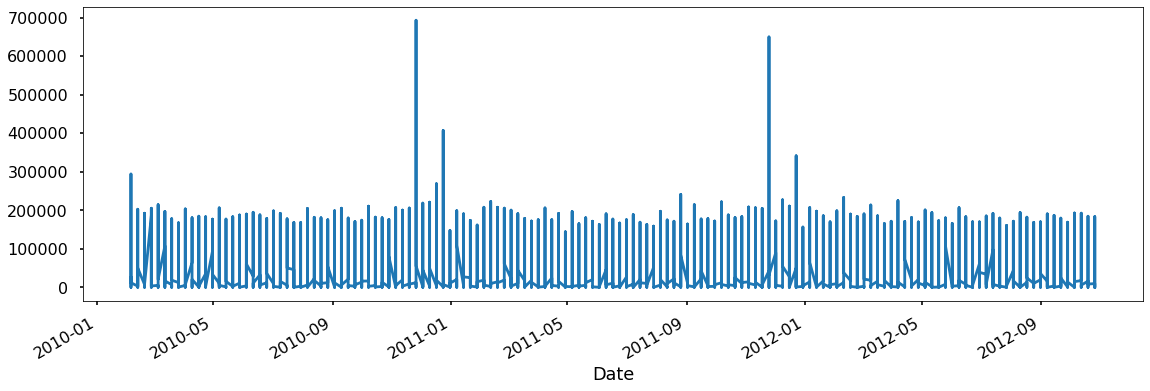

In [45]:
plt.figure(figsize=(19,6))
df['Weekly_Sales'].plot()
plt.show()

There are some repetitive records in the same week, so I will resample the data into weekly sales

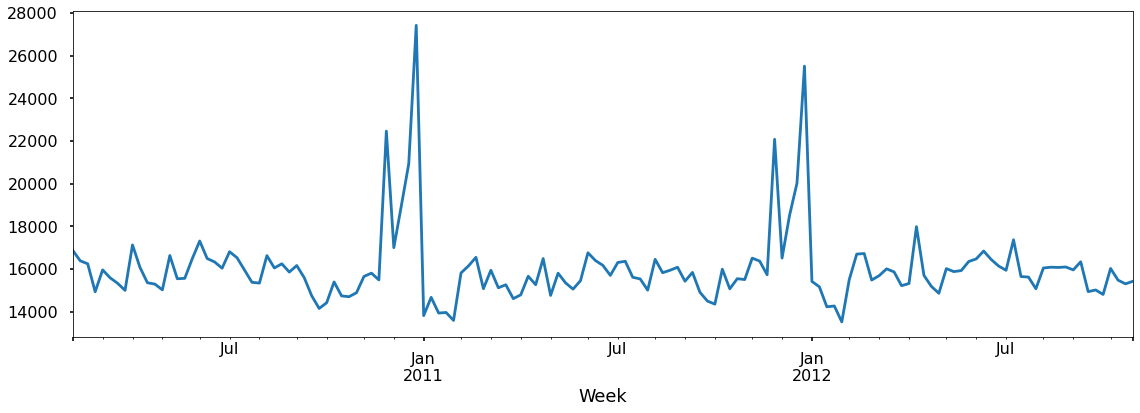

In [46]:
plt.figure(figsize=(19,6))
df_week = df.resample('W').mean()
df_week['Weekly_Sales'].plot().set_xlabel('Week')
plt.show()

For a bigger picture view, I resample the data into monthly sales

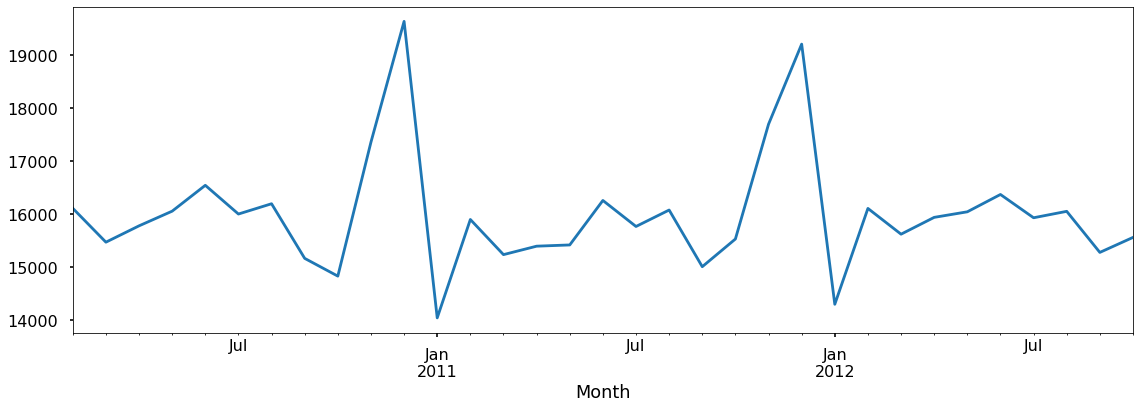

In [47]:
plt.figure(figsize=(19,6))
df_month = df.resample('MS').mean()
df_month['Weekly_Sales'].plot().set_xlabel('Month')
plt.show()

Observations:
* From the 3 line graphs above, we could see  that our sales data is non-stationary: seasonal without a clear trend
* Overall, the dataset is very clean and ready to perform time series forecasting process

Actions:
* Eliminate the seasonality for better fit
* Implement Auto ARIMA and Exponential Smoothing

## 5. Make data more stationary

First, I will use the weekly resampled data to split into train (70%) and test dataset 

In [48]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]
print(train_data.shape)
print(test_data.shape)

(100, 18)
(43, 18)


Assigning X_train, Y_train, X_test, Y_test

In [49]:
var = 'Weekly_Sales'
predictor = [c for c in df_week.columns.to_list() if c not in [var]]

X_train = train_data[predictor]
Y_train = train_data[var]

X_test = test_data[predictor]
Y_test = test_data[var]

Plotting the weekly sales in train and test datasets: blue is train and orange is test

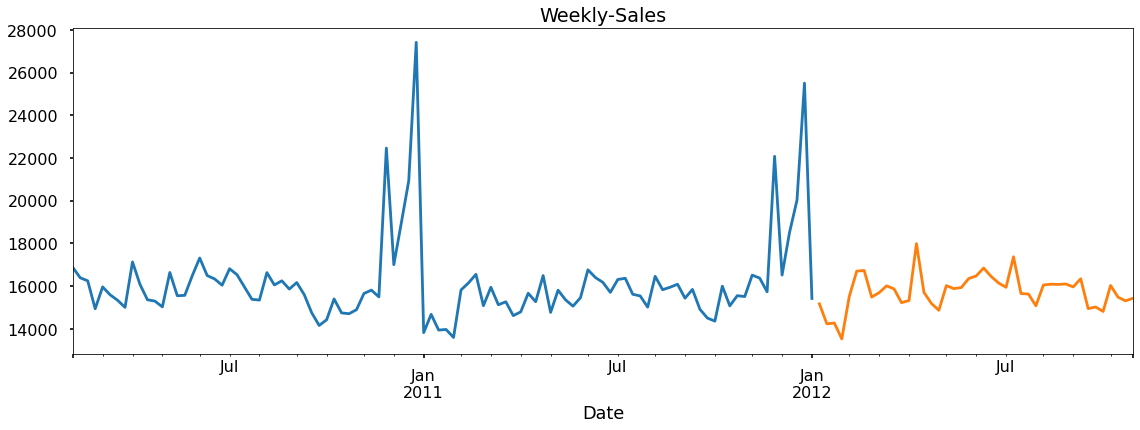

In [50]:
train_data['Weekly_Sales'].plot(figsize=(19,6),title='Weekly_Sales')
test_data['Weekly_Sales'].plot(figsize=(19,6),title='Weekly-Sales')
plt.show()

Here, I start to import libraries needed for further forecast

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

### Decomposition

In [52]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20)

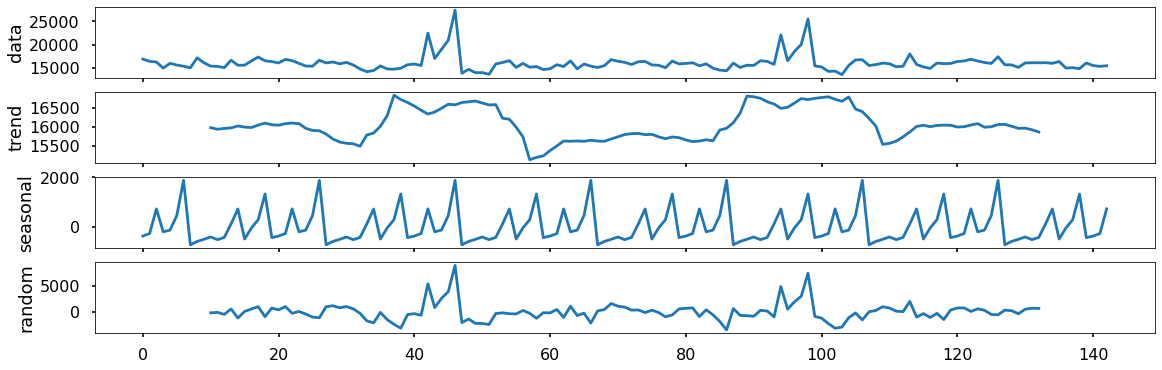

In [53]:
decomposed_plot(decomposed, figure_kwargs={'figsize':(19,6)})
plt.show()

In [54]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna()

In [55]:
diff_roll_mean = df_week_diff.rolling(window=2,center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2,center=False).std()

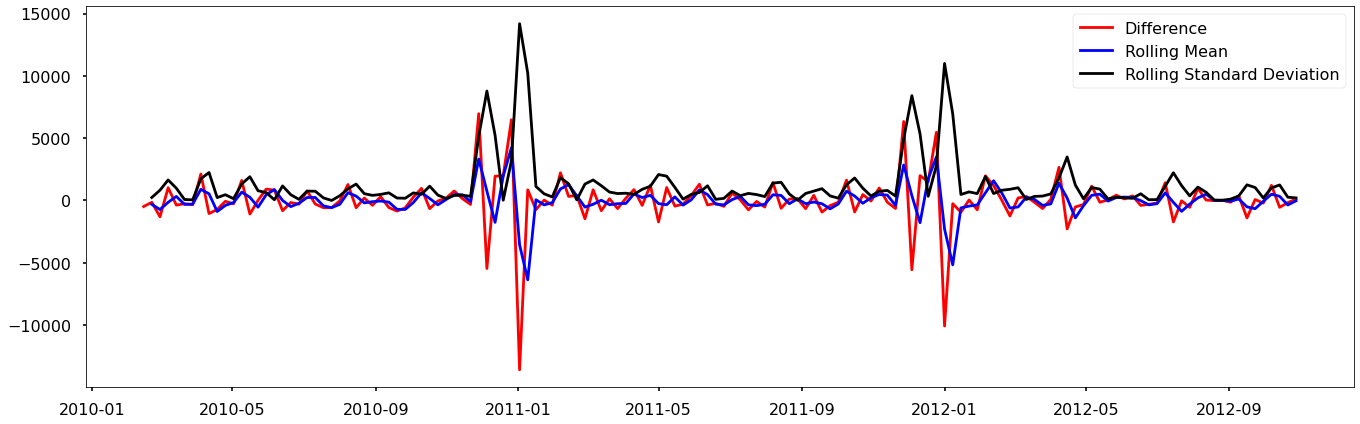

In [56]:
fig,ax = plt.subplots(figsize = (19,6))
ax.plot(df_week_diff, color = 'Red', label = 'Difference')
ax.plot(diff_roll_mean, color = 'Blue', label = 'Rolling Mean')
ax.plot(diff_roll_std, color = 'Black', label = 'Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [57]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna()

In [58]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

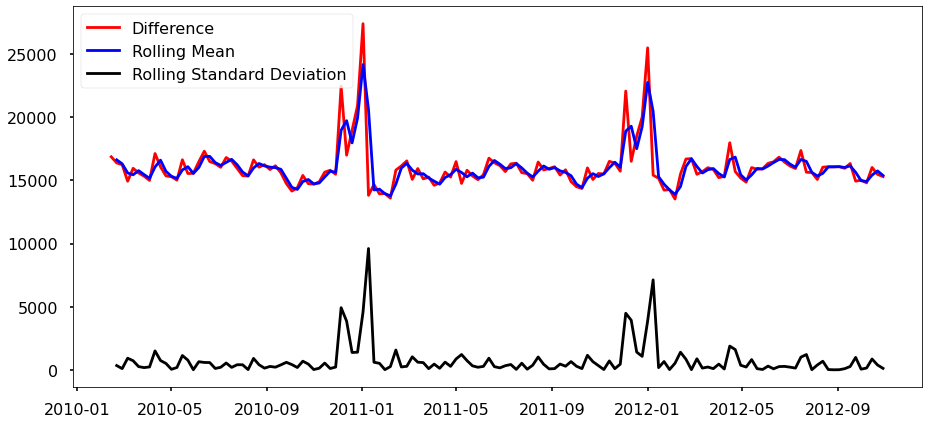

In [59]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='Red',label='Difference')
ax.plot(lag_roll_mean, color='Blue', label='Rolling Mean')
ax.plot(lag_roll_std, color='Black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [65]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna()

In [66]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

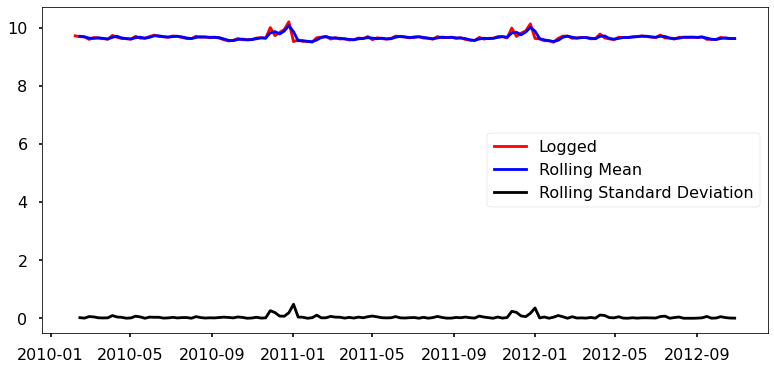

In [68]:
log_roll_meanfig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='Red',label='Logged')
ax.plot(log_roll_mean, color='Blue', label='Rolling Mean')
ax.plot(log_roll_std, color='Black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [69]:
train_data_diff = df_week_diff[:int(0.7*(len(df_week_diff)))]
test_data_diff = df_week_diff[int(0.7*(len(df_week_diff))):]

In [70]:
autoarima_model = auto_arima(train_data_diff, trace=True, start_p=0,start_q=0,start_P=0,start_Q=0,max_p=20,max_q=20,max_P=20,max_Q=20, seasonal=True, maxiter=200, information_criterion='aic',stepwise=False,suppress_warnings=True, D=1, max_D=10, error_action='ignore',approximation=False)
autoarima_model.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.836, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.616, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.531, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.017, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.960, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.194, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.060, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

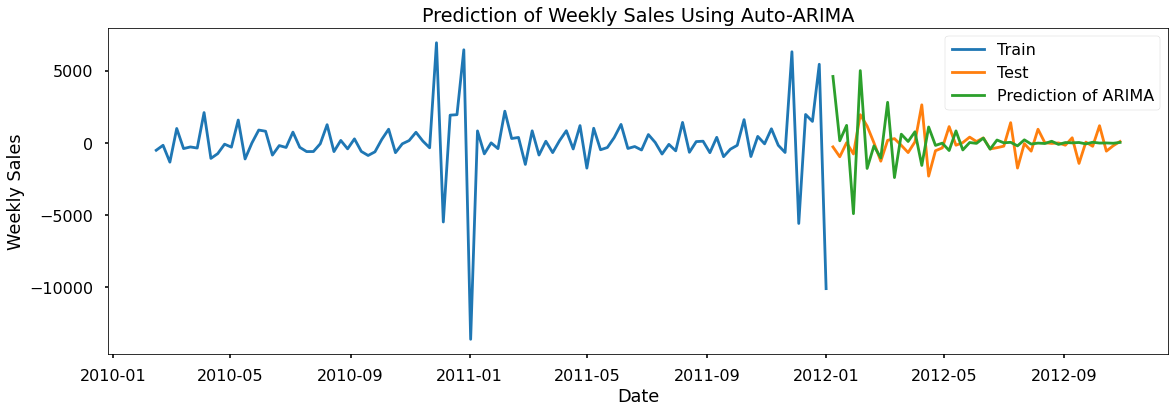

In [71]:
y_pred = autoarima_model.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred, index = test_data.index, columns=['Prediction'])
plt.figure(figsize=(19,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA')
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_21588\1671149481.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  exponential_model = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',trend='additive',damped=True).fit()
c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


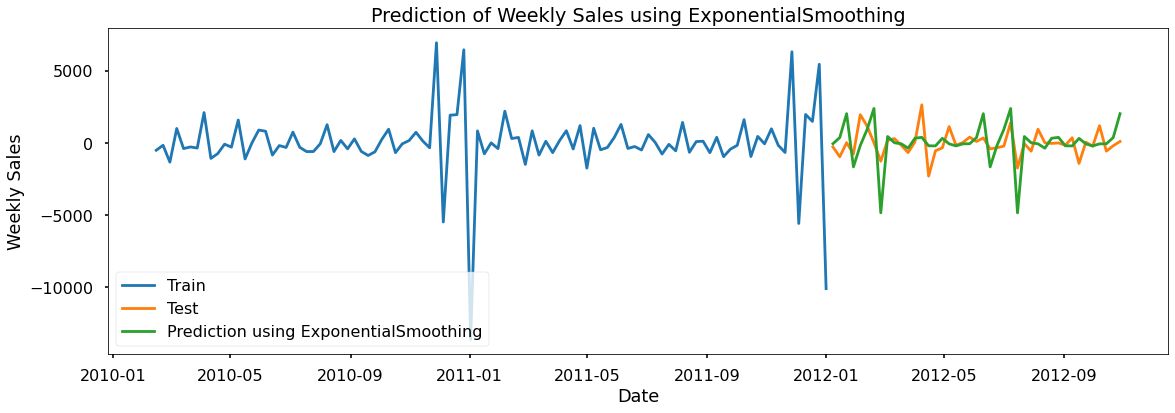

In [73]:
exponential_model = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',trend='additive',damped=True).fit()
y_pred = exponential_model.forecast(len(test_data_diff))

plt.figure(figsize=(19,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing')
plt.plot(train_data_diff,label='Train')
plt.plot(test_data_diff,label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()